# PredictingTotalCup
## Description: 
Experiments with a DecisionTreeClassifier and a RandomForestClassifier to predict total cup score without the 10 quality measures.
## Project name: Not a Latte cool beans
## Author: Natalie Koenig
## Date: 5/11/2022

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 

In [2]:
# Let's start by loading in our train and test datasets
df_train = pd.read_csv('train_data.csv')
df_test = pd.read_csv('test_data.csv')

df_train.head(3)

,Species,Country.of.Origin,Number.of.Bags,In.Country.Partner,Variety,Processing.Method,Aroma,Flavor,Aftertaste,Acidity,...,Cupper.Points,Total.Cup.Points,Moisture,Category.One.Defects,Quakers,Color,Category.Two.Defects,altitude_low_meters,altitude_high_meters,quality
0,Arabica,"Tanzania, United Republic Of",300,Tanzanian Coffee Board,Arusha,Washed / Wet,7.67,7.5,7.33,7.25,...,7.75,82.83,0.11,0,0.0,Green,5,1400.0,1400.0,excellent
1,Arabica,Brazil,25,NUCOFFEE,Mundo Novo,Semi-washed / Semi-pulped,7.75,7.5,7.58,7.50,...,7.58,83.17,0.12,0,0.0,Blue-Green,3,1000.0,1000.0,excellent
2,Arabica,"Tanzania, United Republic Of",1,Africa Fine Coffee Association,Other,Washed / Wet,7.42,7.5,7.50,7.33,...,7.50,82.08,0.12,0,0.0,Green,3,1500.0,1700.0,excellent


In [3]:
df_train.columns[6:17]

Index(['Aroma', 'Flavor', 'Aftertaste', 'Acidity', 'Body', 'Balance',
       'Uniformity', 'Clean.Cup', 'Sweetness', 'Cupper.Points',
       'Total.Cup.Points'],
      dtype='object')

In [4]:
# So now we've loaded in our datasets, first order of business is to drop the
# quality measure columns
df_train = df_train.drop(['Aroma', 'Flavor', 'Aftertaste', 'Acidity', 'Body', 'Balance',
       'Uniformity', 'Clean.Cup', 'Sweetness', 'Cupper.Points', 'Total.Cup.Points', 'Country.of.Origin', 'In.Country.Partner', 'Variety'], axis=1)
df_test = df_test.drop(['Aroma', 'Flavor', 'Aftertaste', 'Acidity', 'Body', 'Balance',
       'Uniformity', 'Clean.Cup', 'Sweetness', 'Cupper.Points', 'Total.Cup.Points', 'Country.of.Origin', 'In.Country.Partner', 'Variety'],axis=1)

# And we'll also shuffle for good measure
df_train = df_train.sample(frac=1.0, random_state=0)
df_test = df_test.sample(frac=1.0, random_state=0)

df_train.head(3)

,Species,Number.of.Bags,Processing.Method,Moisture,Category.One.Defects,Quakers,Color,Category.Two.Defects,altitude_low_meters,altitude_high_meters,quality
1034,Arabica,50,Washed / Wet,0.10,0,0.0,Blue-Green,0,500.0,700.0,very good
124,Arabica,10,Natural / Dry,0.15,1,0.0,None,8,441.0,441.0,excellent
184,Arabica,44,Washed / Wet,0.11,0,0.0,Green,2,950.0,950.0,excellent


In [5]:
# Now we can define our target and features
X_train = df_train.drop(['quality'], axis=1)
X_test = df_test.drop(['quality'], axis=1)

y_train = df_train['quality']
y_test = df_test['quality']

In [6]:
# We'll get dummies for the categorical data and standardize the numerical columns
X_train_num = X_train.select_dtypes(include='number')
X_train_cat = X_train.select_dtypes(exclude='number')

X_train_cat = pd.get_dummies(X_train_cat)
X_train_num = (X_train_num - X_train_num.mean()) / X_train_num.std()

X_train = pd.concat([X_train_num, X_train_cat], axis=1)

X_test_num = X_test.select_dtypes(include='number')
X_test_cat = X_test.select_dtypes(exclude='number')

X_test_cat = pd.get_dummies(X_test_cat)
X_test_num = (X_test_num - X_test_num.mean()) / X_test_num.std()

X_test = pd.concat([X_test_num, X_test_cat], axis=1)

In [7]:
print(X_train.shape)
X_train.head(3)

(1244, 18)


,Number.of.Bags,Moisture,Category.One.Defects,Quakers,Category.Two.Defects,altitude_low_meters,altitude_high_meters,Species_Arabica,Species_Robusta,Processing.Method_Natural / Dry,Processing.Method_Other,Processing.Method_Pulped natural / honey,Processing.Method_Semi-washed / Semi-pulped,Processing.Method_Washed / Wet,Color_Blue-Green,Color_Bluish-Green,Color_Green,Color_None
1034,-0.807907,-0.039962,-0.269278,-0.175172,-0.744302,-0.129194,-0.114575,1,0,0,0,0,0,1,1,0,0,0
124,-1.126193,1.196664,0.102511,-0.175172,0.372432,-0.134124,-0.136221,1,0,1,0,0,0,0,0,0,0,1
184,-0.855650,0.207363,-0.269278,-0.175172,-0.465119,-0.091589,-0.093681,1,0,0,0,0,0,1,0,0,1,0


In [8]:
y_test.value_counts()

excellent    161
very good     21
Name: quality, dtype: int64

In [9]:
# Now let's set up our DecisionTreeClassifier
grid = {'max_depth': np.arange(1, 25)}

Tree = DecisionTreeClassifier()
TreeCV = GridSearchCV(Tree, param_grid=grid, return_train_score=True)

TreeCV.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])},
             return_train_score=True)

In [10]:
print('best depth', TreeCV.best_params_['max_depth'])
print('validation accuracy', TreeCV.best_score_.round(3))

best depth 21
validation accuracy 0.938


In [11]:
best_tree = DecisionTreeClassifier(max_depth=TreeCV.best_params_['max_depth'])
best_tree.fit(X_train, y_train)
print(best_tree.score(X_test, y_test).round(3))

0.753


In [12]:
print(X_train.shape)

(1244, 18)


# Now for RandomForestClassifier:

In [17]:
# Luckily, our training and test data is already defined in terms of targets and features

grid = {'n_estimators': np.arange(10, 200, 10), 'max_depth': np.arange(1, 25)}

rf = RandomForestClassifier()
rfCV = GridSearchCV(rf, param_grid=grid, return_train_score=True, n_jobs=-1)

In [18]:
rfCV.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24]),
                         'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190])},
             return_train_score=True)

In [19]:
print('n_estimators: ', rfCV.best_params_['n_estimators'], '  max_depth: ', rfCV.best_params_['max_depth'])
print('validation accuracy ', rfCV.best_score_.round(3))

n_estimators:  10   max_depth:  19
validation accuracy  0.957


In [20]:
# Now let's see how we do 
best_forest = RandomForestClassifier(n_estimators=rfCV.best_params_['n_estimators'],max_depth=rfCV.best_params_['max_depth'])
best_forest.fit(X_train, y_train)
print(best_forest.score(X_test, y_test).round(3))

0.813


In [22]:
feature_importance = pd.Series(best_forest.feature_importances_, index=X_train.columns)
feature_importance.sort_values(ascending=False)

Category.Two.Defects                           0.192682
Number.of.Bags                                 0.178215
altitude_low_meters                            0.160576
altitude_high_meters                           0.138810
Moisture                                       0.137826
Processing.Method_Washed / Wet                 0.035972
Category.One.Defects                           0.033755
Color_None                                     0.026140
Color_Green                                    0.020062
Processing.Method_Natural / Dry                0.019228
Quakers                                        0.018343
Processing.Method_Semi-washed / Semi-pulped    0.015281
Color_Bluish-Green                             0.007303
Color_Blue-Green                               0.007098
Processing.Method_Other                        0.004127
Species_Robusta                                0.002599
Species_Arabica                                0.001549
Processing.Method_Pulped natural / honey       0

<AxesSubplot:>

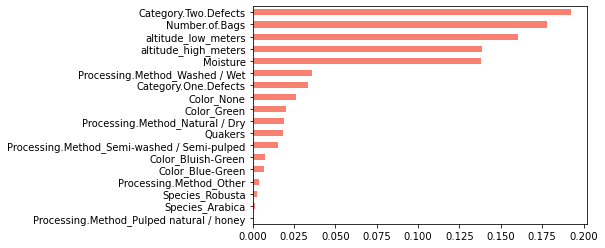

In [23]:
feature_importance.sort_values().plot.barh(color='salmon')